In [21]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

class Control_print():
    ''' model.summary() が巨大すぎるとき
        >>> C = Control_print(fst=初め何行目まで表示するか, lst=最後何行目から表示するか)
        >>> model.summary(print_fn=C.omitted_print)
        で省略表示'''
    def __init__(self, maxcount=1000, fst=10, lst=321):
        self.counter = iter(np.arange(maxcount))
        self.fst = fst
        self.lst = lst
        self.show_dots = True
        
    def omitted_print(self, x):
        line = self.counter.__next__()
        if line < self.fst or line > self.lst:
            print(x)
        elif line==self.lst:
            print("... {} layers ...".format(line - self.fst))
            print("_"*98)
            self.show_dots = False
        else:
            pass
        
class CNNModel(tf.keras.Model): # モデル設計
    def __init__(self, T=1):
        super(CNNModel, self).__init__()
        self.c11 = tf.keras.layers.Conv2D(16, (3,3), padding='same', activation='relu')
        self.c12 = tf.keras.layers.Conv2D(16, (3,3), padding='same', activation='relu')
        self.dr1 = tf.keras.layers.Dropout(0.25)
        self.p1  = tf.keras.layers.MaxPooling2D((2, 2))

        self.c21 = tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu')
        self.c22 = tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu')
        self.dr2 = tf.keras.layers.Dropout(0.25)
        self.p2  = tf.keras.layers.MaxPooling2D((2, 2))

        self.flat = tf.keras.layers.Flatten()
        self.l1 = tf.keras.layers.Dense(128,activation = "relu")
        self.dr3= tf.keras.layers.Dropout(0.5)
        self.l2 = tf.keras.layers.Dense(10)
        self.sigma = tf.keras.layers.Activation('softmax')

        self.T = 1
        
    def call(self, x):
        h = self.c11(x)
        h = self.c12(h)
        h = self.dr1(h)
        h = self.p1(h)

        h = self.c21(h)
        h = self.c22(h)
        h = self.dr2(h)
        h = self.p2(h)

        h = self.flat(h)
        h = self.l1(h)
        h = self.dr3(h)
        h = self.l2(h)
        return self.sigma(h/self.T)
    
    def summary(self, print_fn):
        x = tf.keras.Input(shape=(32, 32, 3))
        return (tf.keras.Model(inputs=x, outputs=self.call(x))).summary(print_fn=print_fn)
        
def one_hot(y):
    out = np.zeros(10)
    out[y] = 1
    return out

def prob(model, x):
    x = x.reshape(1,32,32,3).astype(np.float32)
    y = model(x).numpy().reshape(10)
    return y

def batch_step(X, Y, model, optimizer): # 学習ステップ
    with tf.GradientTape() as tape:
        Y_pred = model(X) 
        loss_value = L(Y, Y_pred) 
    grads = tape.gradient(loss_value, model.trainable_variables) 
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss_value
    
def return_tf_batch(X, Y, batch_size): # バッチ処理
    X_32bits, Y_32bits = X.astype(np.float32), Y.astype(np.float32)
    dataset = tf.data.Dataset.from_tensor_slices((X_32bits, Y_32bits))
    dataset = dataset.shuffle(len(X), reshuffle_each_iteration=False) 
    return dataset.batch(batch_size=batch_size).as_numpy_iterator()

def measure(model, X_test, Y_test):
    return np.mean(np.argmax(model.predict(X_test), axis=1) == Y_test.reshape(10000))
        
##### CIFAR-10 #####
cifar10 = tf.keras.datasets.cifar10 
(X, Y), (X_test, Y_test) = cifar10.load_data()
X, X_test = X/255, X_test/255

## 6-3. 転移学習
ここまで、機械学習を使う際には、訓練と実践の2種類のパターンがあることを大前提として説明してきました。機械学習の目的は

* データ生成確率 $p({\bf x})$, $p(y|{\bf x})$ があって
* モデル確率 $q({\bf x}), q(y|{\bf x})$ をこれらに近づける

ことで、そうすれば $p$ の振る舞いを予言することができるという理屈でした。このことは暗黙のうちに、**訓練と実践でデータが従う確率分布が同じ**であることを仮定しています。しかし、場合によっては訓練で手に入るデータと実践データが異なる場合も有りますし、ここまで説明してきたようなきれいな設定が適用できるケースはむしろ稀でしょう。**転移学習(transfer learning)** はここまでの機械学習の設定をより一般化した、機械学習を定式化するより広い枠組みであり、これから益々重要になってくる考え方だと思います。そこでこの節では、転移学習におけるいくつかの用語（分野が盛り上がり始めてから日が浅いためか様々な用語が散在）を説明し、教師あり学習の文脈での転移学習の例をデモンストレーションします。

### ドメイン
教師あり学習では、入力 ${\bf x}$、出力 $y$ (これは必ずしもスカラー値とは限らないけれど、見た目で区別しやすいので太字にはしない）がそれぞれ

* ${\bf x}$ は何らかの（入力）データ生成確率 $p_X({\bf x})$ に従う。ここで $X$ は ${\bf x}$ が属する空間
* $y$ も何らかの（教師信号）データ条件付き確率 $p_{Y|X}(y|{\bf x})$ に従う。ここで $Y$ は $y$ が属する空間

としていました。これはもちろん、

$$
p_{X, Y}({\bf x},y) =  p_{Y|X}(y|{\bf x})p_X({\bf x})
$$

の存在を仮定して周辺化しても同じです。データ=$({\bf x}, y)$ の住む空間＝$X \times Y$ と、その上の確率分布 $p_{X, Y}$ の組のことを、**ドメイン(domain)** と呼びます。例えば

- **MNIST(ラベル付き)のドメイン：**
    - $X = \mathbb{R}^{28 \times 28 \times 1}, Y = \{0,1,2, \dots, 9\}$として、$p_X({\bf x})=$28x28のグレイスケール手書き数字の画像生成確率、$p_{Y|X}(y|{\bf x})=$画像を見て、どの数字か認識する確率
- **CIFAR-10(ラベル付き)のドメイン：**
    - $X = \mathbb{R}^{32 \times 32 \times 3}, Y = \{\text{飛行機}(0), \text{自動車}(1), \text{鳥}(2), \dots, \text{トラック}(9)\}$として、$p_X({\bf x})=$32x32x3のRGBカラー画像の生成確率、$p_{Y|X}(y|{\bf x})=$画像を見て、どのラベルか認識する確率
    
といった具合です。

### 転移学習の目標
例えば、$(X\times Y, p_{X \times Y})$ をMNIST(ラベル付き)のドメインとして、このドメインからのサンプリング（データ）は手に入るわけですが、それを

- **近所の郵便局に運び込まれるハガキの郵便番号ドメイン**

と同じという保証は全くありません。実際、どのように郵便番号を電子化するかによって画像サイズも変わりますし、チャネル数も変わります。これは $X$ の変化ですが、$p_X$、つまり出てくる画像の従う確率分布も日本とアメリカの人々の手癖は違うでしょうから異なりますし、そこが異なると当然どの画像を7と判断すべきかのルール $p_{Y|X}$ も変わってくるでしょう。

このように、元とするドメイン（**ソース・ドメイン**）と運用したい先の目標のドメイン（**ターゲット・ドメイン**）は異なるのが一般的です。転移学習では、ソース・ドメインの情報（データや訓練モデルなど）を用いて、ターゲット・ドメインでの汎化を目的とします：

$$
\text{source domain} \to \text{Generalization(target domain)}
$$




これまで、アヤメデータやMNIST、CIFAR-10での実験は全てソース＝ターゲットの前提の元で説明していましたから、これまでの話は転移学習の特殊な場合に含まれると言えます。



### 簡単なデモンストレーション
これまで紹介してこなかった気がしますが、画像系のデータベースで最大規模のものに**ImageNet**と呼ばれるものがあります。これは入力画像データはまちまちですが、高画質の画像と、それに1,000ラベルが着けられた、およそ100万個のサンプルから成るデータベースです。画像認識ニューラルネットワークのState-Of-The-Artモデルの多くは、このデータセットで訓練されたモデルパラメータを公開しています。例えば以下では [arXiv:1801.04381](https://arxiv.org/abs/1801.04381) で提案された、軽量なImageNet訓練済みモデルのMobileNetV2を（初回はダウンロードして）読み込むコマンドです：

In [66]:
# MobileNetV2 is distributed under Apache License 2.0: https://github.com/tensorflow/models/blob/master/LICENSE
base_model = tf.keras.applications.MobileNetV2(weights='imagenet', input_shape=(96, 96, 3), include_top=False, pooling='avg')
C = Control_print()
base_model.summary(print_fn=C.omitted_print)

Model: "mobilenetv2_1.00_96"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 97, 97, 3)    0           input_14[0][0]                   
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 48, 48, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
... 311 layers ...
__________________________________________________________________________________________________
out_relu (ReLU)                 (None, 3, 3, 1280)   0       

軽量とは言っても、およそ**300層**という、ここまでの講義で作ってきたネットワークに比べるとより深層なモデルです。これはImageNetのソース・ドメインを与えられて訓練されたモデルなわけですが、このモデルをターゲット・ドメイン＝CIFAR-10 への転移学習に使ってみましょう。転移学習のやり方にも色々ありますが、今回は単純に

1. CIFAR-10の入力shape:(32, 32, 3) をリサイズ（拡大）して(96, 96, 3) にする
2. MobileNetV2専用の前処理にかける
3. これをMobileNetV2に入力し、1280次元の出力を得る
4. 1280次元のベクトルから10次元ベクトルに`Dense`で変換し、softmax活性化

でCIFAR-10の10クラス分類モデルを作ります。このモデルをCIFAR-10で訓練してみます。ただし、ここでは、計算時間削減のためMobileNetV2のパラメータはいじらず、4番の線形変換**のみ**訓練対象とします。以下のクラスが1~4の処理をするモデルの実装です：

In [69]:
class TransferModel(tf.keras.Model): # モデル設計
    def __init__(self, T=1):
        super(TransferModel, self).__init__()
        # MobileNetV2 is distributed under Apache License 2.0: https://github.com/tensorflow/models/blob/master/LICENSE
        self.base_model = tf.keras.applications.MobileNetV2(weights='imagenet', input_shape=(96, 96, 3), include_top=False, pooling='avg')
        self.l = tf.keras.layers.Dense(10)
        self.sigma = tf.keras.layers.Activation('softmax')
        self.base_model.trainable = False
        self.T = 1
        
    def call(self, x):
        x = 255.0*x # MobileNetV2入力レンジは0~255で設定されているようです
        h = tf.image.resize(x, (96, 96))
        h = tf.keras.applications.mobilenet_v2.preprocess_input(h)
        h = self.base_model(h)
        h = self.l(h)
        return self.sigma(h/self.T)
    
    def summary(self):
        x = tf.keras.Input(shape=(32, 32, 3))
        return (tf.keras.Model(inputs=x, outputs=self.call(x))).summary()

>注意ですが、どうやら`tf.keras.Model`を継承して上のようにクラスで書くのは、keras Functional API（上での`summary`関数の再実装に使っている`model = tf.keras.Model(inputs, outputs)`のようにしてモデルを作る方法）に比べると、やや訓練速度が劣るようです。今回は説明の便宜上、上の実装にしました。`summary`関数で使っているので二度手間感がありますが…

入力画素値は初めから0-255でも良かったのですが、今まで0-1に設定していたのでそれに合わせました。モデルのサマリーを見ると1から4の処理が行われているのが確認できます。

In [70]:
model_tr = TransferModel()
model_tr.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
tf_op_layer_mul_1 (TensorFlo [(None, 32, 32, 3)]       0         
_________________________________________________________________
tf_op_layer_resize_5/ResizeB [(None, 96, 96, 3)]       0         
_________________________________________________________________
tf_op_layer_truediv_4 (Tenso [(None, 96, 96, 3)]       0         
_________________________________________________________________
tf_op_layer_sub_4 (TensorFlo [(None, 96, 96, 3)]       0         
_________________________________________________________________
mobilenetv2_1.00_96 (Model)  (None, 1280)              2257984   
_________________________________________________________________
dense_7 (Dense)              (None, 10)                1281

早速訓練してみます。3エポック程度で十分です：

In [71]:
model_tr.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
Hist= model_tr.fit(X, Y, epochs=3, verbose=1, validation_data=(X_test, Y_test))

Epoch 1/3
1563/1563 [==============================] - 40s 26ms/step - loss: 0.5264 - accuracy: 0.8217 - val_loss: 0.4284 - val_accuracy: 0.8506
Epoch 2/3
1563/1563 [==============================] - 39s 25ms/step - loss: 0.3894 - accuracy: 0.8679 - val_loss: 0.4253 - val_accuracy: 0.8570
Epoch 3/3
1563/1563 [==============================] - 39s 25ms/step - loss: 0.3555 - accuracy: 0.8763 - val_loss: 0.4122 - val_accuracy: 0.8588


Validation精度が85%程度を達成するのがわかりますが、**これは[6-1](#6-1-まだ解説していないテクニック)にて作ったアンサンブル模型の精度~75%を大幅に更新しています**。これはMobileNetV2がImageNetをもちいた訓練の過程で、自然画像の判別に有用な特徴量を抽出するようになっているから可能になったと思われます。このように、ImageNetドメインから、上手くCIFAR-10ドメインに転移学習させることができました。
> ここではいかにも高精度の分類器ができた！と言わんばかりなので補足しておきますが、調べてみると85%は2013年くらいの最高精度で、最近は99%周辺争いのようです。残念。

### Fine tuning
上のデモではソース・ドメインのモデルは一切変更せず（`self.base_model.trainable = False`）に最後の線形変換のみを訓練しましたが、ターゲット・ドメインのタスクを解く際に、ソース・ドメインのモデルパラメータを固定しなくても良いでしょう。こちらも更に上手く調整することをしばしば**ファインチューニング**と呼ぶようですが、今回は深入りしません。



### モデルの蒸留
その代わりに、最後にモデルの蒸留（[arXiv:1503.02531](https://arxiv.org/abs/1503.02531)）と呼ばれるモデル軽量化のテクニックを説明します。ここまでで、MobileNetV2+Denceによる、巨大な（我々が作ったCIFAT-10分類器のなかでは最高精度の）モデルを手に入れたわけですが、いささか巨大過ぎるモデルは色々扱いに困ります。そこで、**より軽量な「生徒」モデルを、巨大な「教師モデル」を用いて訓練する**のはどうか、と考えてみます。たとえば以下のようなモデル：


In [8]:
model = CNNModel()
C = Control_print(fst=8, lst=29)
model.summary(print_fn=C.omitted_print)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 32, 32, 16)        448       
_________________________________________________________________
... 21 layers ...
__________________________________________________________________________________________________
tf_op_layer_truediv_3 (Tenso [(None, 10)]              0         
_________________________________________________________________
activation_4 (Activation)    (None, 10)                0         
Total params: 280,218
Trainable params: 280,218
Non-trainable params: 0
_________________________________________________________________


を考えてみます。これはパラメータ数でいうと転移学習で作った「教師」モデルの1/10程度のモデルです。
#### なぜ教師モデルを使うと良いと期待されるか
分類問題をデータから解かせるとき、相互エントロピー誤差はデータ生成確率分布そのものではなく経験確率

$$
\hat{p}_N({\bf x}, y) = \frac{1}{N} \sum_{n=1}^N
 \delta(y-y_n, {\bf x} - {\bf x}_n), \quad
\hat{p}_N(y|{\bf x}) = \frac{\hat{p}_N({\bf x}, y)}{\hat{p}_N({\bf x})} 
 $$
 
を用いたモデル $q(y|{\bf x})$ との KL距離

$$
D_{KL}(\hat{p} \| q) \approx \Big\langle \log \frac{q(y|{\bf x})}{\hat{p}_N(y|{\bf x})} \Big\rangle_{y \sim \hat{p}(y|{\bf x}), {\bf x} \sim \hat{p}_N({\bf x})}
$$

に対応していたのでした。ここで、データそのものではなく「教師ネットワーク」$r(y|{\bf x})$ を用いて $q$ を訓練するには、

$$
D_{KL}(r\|q) \approx \Big\langle \log \frac{q(y|{\bf x})}{r(y|{\bf x})} \Big\rangle_{y \sim r(y|{\bf x}), {\bf x} \sim \hat{p}_N({\bf x})}
$$

を $q$ を動かして減らすことに他なりません。これは $\hat{p}_N$ が「正解のみ1他0」ということよりも明らかに多くの情報を $r$ が持っているはずだということです。例えば


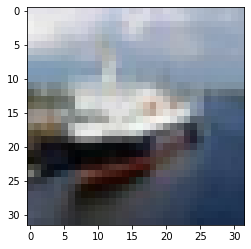

data answer: [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
teacher output: [2.3899720e-05 8.9168005e-08 1.6611683e-08 2.0855557e-08 2.8456734e-08
 4.7532012e-10 3.6386442e-08 8.7007374e-10 9.9997592e-01 2.1505276e-08]


In [6]:
model_tr.trainable = False # 教師モデルは凍結しておく
n = np.random.randint(len(Y_test))
plt.imshow(X_test[n]); plt.show()
print("data answer:", one_hot(Y_test[n]))
print("teacher output:", prob(model_tr, X_test[n]))

を見ると、データの「答え」程の最大のシャープネスを教師ネットワークは持っていません。ほとんど1に近い出力の中でも、0ではない値がある部分が幾らかあり、そこが生徒ネットワークにとって、データの「答え」だけでは得られない**知識**になっている（これを**dark knowledge**と呼びます）というわけです。

蒸留は、教師ネットワークの、文字通り**知識の蒸留**を試みるものです。知識の蒸留とはナンノコッチャ、という感じがしますが、もちろん化学における蒸留そのものではないわけですが、それに思想としてはかなり近いことをやります。

基本的には教師ネットワークの出力を教師信号と読み替えた生徒モデルの教師あり学習を、相互エントロピー誤差を用いて行う
> 実際はデータとの相互エントロピー誤差と教師ネットワークとの相互エントロピー誤差の2つを適当に重み付けしたものを使う用に思いますが、今回は簡略化で教師ネットワークとの誤差のみを用います。

わけですが、ただこれをやるだけでは、折角ラベル毎に確率値が振られていても、どれかがほぼ1で他の値がすごく小さければ教師付きデータでの学習とあまり差が無くなってしまいます。それを避けるために**温度**を導入し、「高温からだんだんと冷やしていくことで知識を蒸留する」のがポイントです。そのために、モデルがsoftmax出力

$$
q(y_i = 1 | {\bf x})=
\frac{e^{ v_i({\bf x}) }}{
\sum_j e^{v_j({\bf x})}}
$$

だとして、これを統計力学と考え、温度を導入します：

$$
q^T(y_i = 1 |{\bf x})=
\frac{e^{ v_i({\bf x})/T }}{
\sum_j
e^{v_j({\bf x})/T}}
$$

教師モデルも同様に温度入りのソフトマックス

$$
r^T(y_i=1|{\bf x})=
\frac{e^{z_i({\bf x})/T}}{
\sum_j
e^{z_j({\bf x})/T}
}
$$

として、誤差関数

$$
L^T(q, {\bf x}) = -
\sum_{i}
r^T(y_i=1|{\bf x})
\log {q^T(y_i=1|{\bf x})}
$$

を使ったSGD更新を、初めは高温$T\approx$大でやり、教師の知識が伝達しやすくしておき、徐々に低温に持っていきながら訓練を行うことでそれを洗練させると言う狙いです。実際にやってみましょう：

#### 蒸留なし：これまで通りの普通の訓練

In [18]:
%%time
L = tf.keras.losses.SparseCategoricalCrossentropy() # 誤差関数, Sparse...になっているのに注意、蒸留の場合は別のものを使う
model = CNNModel()
optimizer=tf.keras.optimizers.Adam()
tf_batch_step = tf.function(batch_step)
N_epoch = 8

for epoch in range(N_epoch):
    batch = return_tf_batch(X, Y, batch_size=38)
    for (x,y) in batch:
        loss_value = tf_batch_step(x, y, model, optimizer)
    print("epoch {}/{}, T={}, val_accuracy:{}".format(epoch+1, N_epoch, 1, measure(model, X_test, Y_test)))

epoch 1/8, T=1, val_accuracy:0.6096
epoch 2/8, T=1, val_accuracy:0.6754
epoch 3/8, T=1, val_accuracy:0.6788
epoch 4/8, T=1, val_accuracy:0.7105
epoch 5/8, T=1, val_accuracy:0.7194
epoch 6/8, T=1, val_accuracy:0.7185
epoch 7/8, T=1, val_accuracy:0.7238
epoch 8/8, T=1, val_accuracy:0.717
CPU times: user 38.5 s, sys: 2.45 s, total: 40.9 s
Wall time: 35.6 s


#### 蒸留あり：

In [19]:
#%%time forループ中でtf.functionを使うと、timeマジックコマンドとなぜか競合する…
import time
t0 = time.time()
L = tf.keras.losses.CategoricalCrossentropy(from_logits=False) # 誤差関数
model = CNNModel()
optimizer=tf.keras.optimizers.Adam()
tf_batch_step = tf.function(batch_step)
T, decay = 20, 0.7
N_epoch = 8

for epoch in range(N_epoch):
    batch = return_tf_batch(X, Y, batch_size=38)
    T = T*decay    # 温度をエポック毎に下げていく処理
    model_tr.T = T # 教師モデルの温度を今の温度に設定
    model.T = T    # 生徒モデルの温度を今の温度に設定
    teacher = tf.function(lambda x: model_tr(x, training=False))# これをやらないと圧倒的に遅くなる
    for (x,_) in batch:
        y = teacher(x) # 教師信号はデータではなく、教師ネットワークの出力値
        loss_value = tf_batch_step(x, y, model, optimizer) 
    print("epoch {}/{}, T={:.2}, val_accuracy:{}".format(epoch+1, N_epoch, T, measure(model, X_test, Y_test)))
t1 = time.time(); print("Wall time: {:.1} s".format(t1-t0))

epoch 1/8, T=1.4e+01, val_accuracy:0.5717
epoch 2/8, T=9.8, val_accuracy:0.6414
epoch 3/8, T=6.9, val_accuracy:0.6854
epoch 4/8, T=4.8, val_accuracy:0.7143
epoch 5/8, T=3.4, val_accuracy:0.7242
epoch 6/8, T=2.4, val_accuracy:0.7274
epoch 7/8, T=1.6, val_accuracy:0.7507
epoch 8/8, T=1.2, val_accuracy:0.7484
Wall time: 1e+02 s


このように、蒸留したほうが精度が良くなります。ただし訓練にかかる時間は、教師ネットワークが巨大なため、教師信号を得るところがボトルネックになっているのに注意。とくに、教師ネットワークを用いて教師信号を作るところで時間を食いますから、`tf.function()`で一旦囲って使ったほうが良いです。これをやるのとやらないので全然かかる時間が違います（ただし、これで教師モデルの温度変更がきちんと反映されているかはチェックしていません）。また、ここでは転移学習で得たモデルを教師としましたが、アンサンブルを教師にするなど色々考えられると思います。

#### Born again Neural Network
このように知識の蒸留は基本的には、教師モデルよりも軽量な生徒モデルを作ることが主眼だったわけですが、[arXiv:1805.04770](https://arxiv.org/abs/1805.04770)では**教師モデル構造＝生徒モデル構造**として、2回同じ構造のネットワークを
1. 1回目は普通に教師あり学習させ、得たモデルを教師モデルとし
2. 2回目は教師モデルのdark knowledgeを用いて同じ構造の生徒モデルを訓練する

ということをやると、なんと**生徒モデルのほうが汎化性能が上がる場合がある**ことを報告しており、これを「Born Again Neural Network」とよんでいます。これはなかなか驚きでした。

#### Defensive distillation
また、蒸留して作られたモデルはadversarial attackに対して強くなっているらしいです（[arXiv:1511.04508](https://arxiv.org/abs/1511.04508)）これは、蒸留をすると序盤で高温下での訓練をするわけですが、JSMAアタックに使うための勾配出力が概ね$1/T$倍の修正を受けるため、脆弱なピクセルが出来づらいということらしいです。ここで実際に実験できましたが、割愛します。